# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

In [3]:
# Загрузим все необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np
import lightgbm as lgb
import lightgbm as lgm
import warnings
import copy
import time

from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None # полностью отображаем столбцы

In [4]:
try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    autos = pd.read_csv('D:/DS/datasets/autos.csv')
    
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
n_rows_start = len(autos)

In [7]:
print(autos.duplicated().sum())

autos = autos.drop_duplicates().reset_index(drop=True)

4


Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [8]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


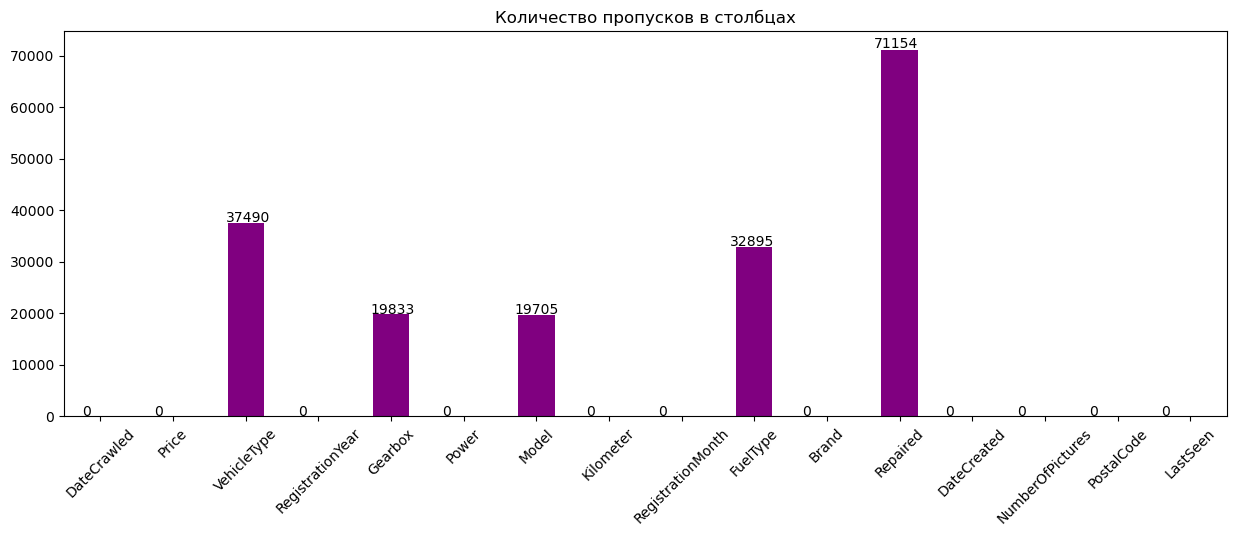

In [9]:
# рассмотрим пропуски в столбцах

plt.figure(figsize=(15,5))
ax = autos.isna().sum().plot.bar(color='purple', rot=45)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.99, p.get_height() * 1.005))
plt.title('Количество пропусков в столбцах')
plt.show()

Выводы:

- В некоторых столбцах присутствуют выбросы, причем очень странного характера. Скорее всего это артефакты
- Есть пропуски значений в категориальных столбцах. В численных нет.
- Столбец с количеством фотографии - не содержит ничего. Все значения 0.

Удалим ненужные колонки и отдельно выделим категориальные:

In [10]:
autos.columns = ['DateCrawled', 'Price', 'VehicleType_cat', 'RegistrationYear', 'Gearbox_cat',
       'Power', 'Model_cat', 'Kilometer', 'RegistrationMonth', 'FuelType_cat', 'Brand_cat',
       'Repaired_cat', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen']

autos = autos.drop(['DateCrawled','DateCreated','LastSeen','NumberOfPictures', 'PostalCode'], axis=1)

category_columns = ['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat',
           'Brand_cat', 'RegistrationMonth_cat', 'Repaired_cat']

In [11]:
print(autos.duplicated().sum())

autos = autos.drop_duplicates().reset_index(drop=True)

27539


In [12]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType_cat    291577 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox_cat        309248 non-null  object
 4   Power              326826 non-null  int64 
 5   Model_cat          308294 non-null  object
 6   Kilometer          326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType_cat       295704 non-null  object
 9   Brand_cat          326826 non-null  object
 10  Repaired_cat       260399 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


In [13]:
all_nan = autos.isna().sum()
all_nan

Price                    0
VehicleType_cat      35249
RegistrationYear         0
Gearbox_cat          17578
Power                    0
Model_cat            18532
Kilometer                0
RegistrationMonth        0
FuelType_cat         31122
Brand_cat                0
Repaired_cat         66427
dtype: int64

In [14]:
perc_nan = all_nan / autos.shape[0]
perc_nan.sort_values(ascending=False)

Repaired_cat         0.203249
VehicleType_cat      0.107852
FuelType_cat         0.095225
Model_cat            0.056703
Gearbox_cat          0.053784
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand_cat            0.000000
dtype: float64

D:\Programs\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Programs\anaconda3\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

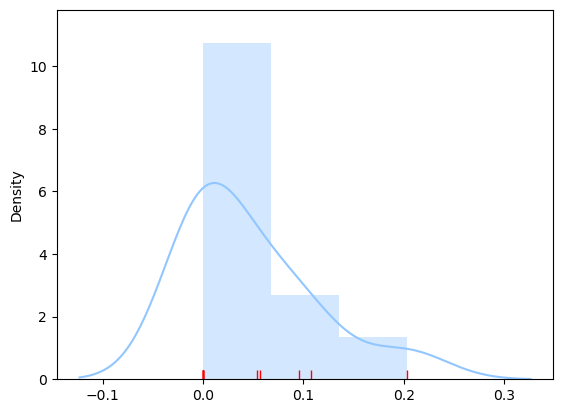

In [15]:
sns.distplot(perc_nan, rug=True, rug_kws={"color": "r"})

Чтобы не удалять много строк с пустыми значениями, заполним все категориальные значения значением `unknown`:

In [16]:
autos = autos.fillna('unknown')

In [17]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType_cat    326826 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox_cat        326826 non-null  object
 4   Power              326826 non-null  int64 
 5   Model_cat          326826 non-null  object
 6   Kilometer          326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType_cat       326826 non-null  object
 9   Brand_cat          326826 non-null  object
 10  Repaired_cat       326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.4+ MB


In [18]:
n_rows_end = len(autos)

In [19]:
# вычисляем общий процент удаленных данных
percent_deleted_total = (n_rows_start - n_rows_end) / n_rows_start * 100

# выводим результат
print(f'Общий процент удаленных данных: {percent_deleted_total:.2f}%')

Общий процент удаленных данных: 7.77%


In [20]:
autos['Repaired_cat'].value_counts()

no         225970
unknown     66427
yes         34429
Name: Repaired_cat, dtype: int64

In [21]:
autos['VehicleType_cat'].value_counts()

sedan          83602
small          73496
wagon          59662
unknown        35249
bus            26795
convertible    18752
coupe          15120
suv            10977
other           3173
Name: VehicleType_cat, dtype: int64

D:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


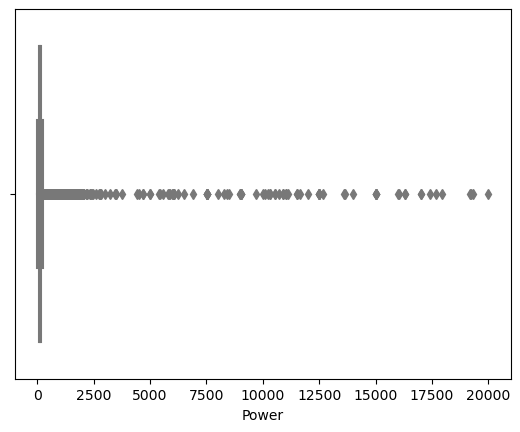

D:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


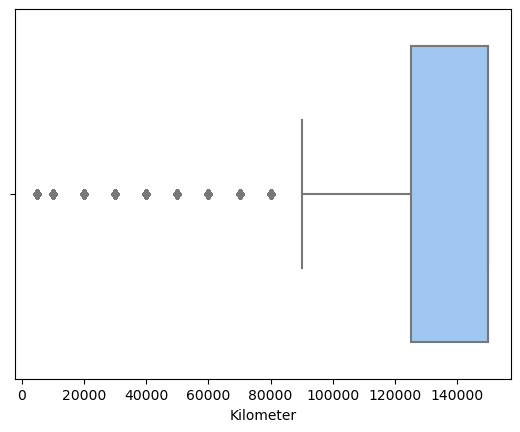

D:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


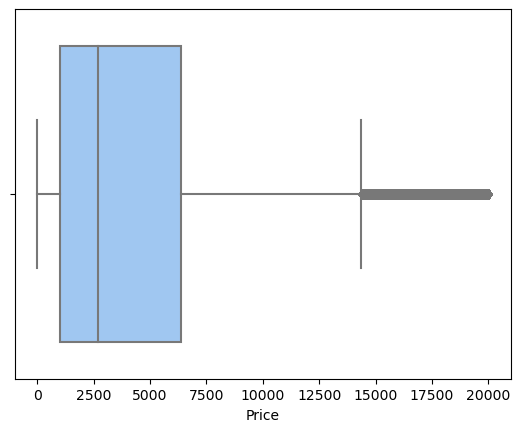

In [22]:
for a in ['Power','Kilometer','Price']:
    sns.boxplot(autos[a]) 
    plt.show()

Видим явные аномалии в цене. Также много нулевых значений в цене и мощности - их можно заменить средним значением. Сделаем сводные таблицы и в них заменим на средние, а затем применим их к основному датасету

Уберем цены ниже 100 евро и нулевые значения мощностей

In [23]:
autos = autos.query('Power != 0')
autos = autos.query('Price > 100')
power_new = autos.pivot_table(columns='Model_cat', values='Power', aggfunc='mean').astype('int').to_dict()
price_new = autos.pivot_table(columns='Model_cat', values='Price', aggfunc='mean').astype('int').to_dict()

In [24]:
def fill_0(row, cat, place, table):
    a = row[cat]
    b = table[a][place]
    if row[place] == 0:  
        row[place] = b
    return row
        
autos = autos.apply(fill_0, axis=1, args=('Model_cat','Power', power_new))
autos = autos.apply(fill_0, axis=1, args=('Model_cat','Price', price_new))

autos.head(20)

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes


In [25]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281770 entries, 1 to 326825
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              281770 non-null  int64 
 1   VehicleType_cat    281770 non-null  object
 2   RegistrationYear   281770 non-null  int64 
 3   Gearbox_cat        281770 non-null  object
 4   Power              281770 non-null  int64 
 5   Model_cat          281770 non-null  object
 6   Kilometer          281770 non-null  int64 
 7   RegistrationMonth  281770 non-null  int64 
 8   FuelType_cat       281770 non-null  object
 9   Brand_cat          281770 non-null  object
 10  Repaired_cat       281770 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.8+ MB


Данные готовы к построению моделей

Рассмотрим артефакты:

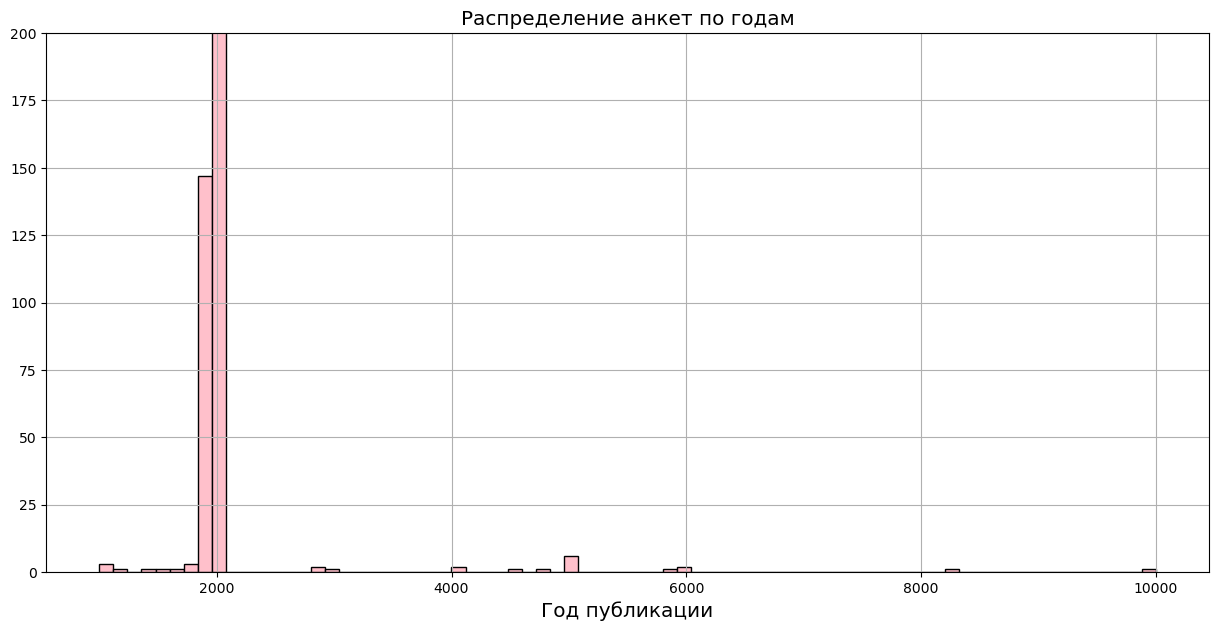

In [26]:
plt.figure(figsize=(15,7))
plt.ylim(0,200)
autos['RegistrationYear'].hist(bins=75, edgecolor='k', color='pink')
plt.title('Распределение анкет по годам', fontsize='x-large')
plt.xlabel('Год публикации', fontsize='x-large')
plt.show()

По графику мы видим, что год публикации анкет по годам лежит в пределах 1920-2020 годы, что выглядит адекватно.

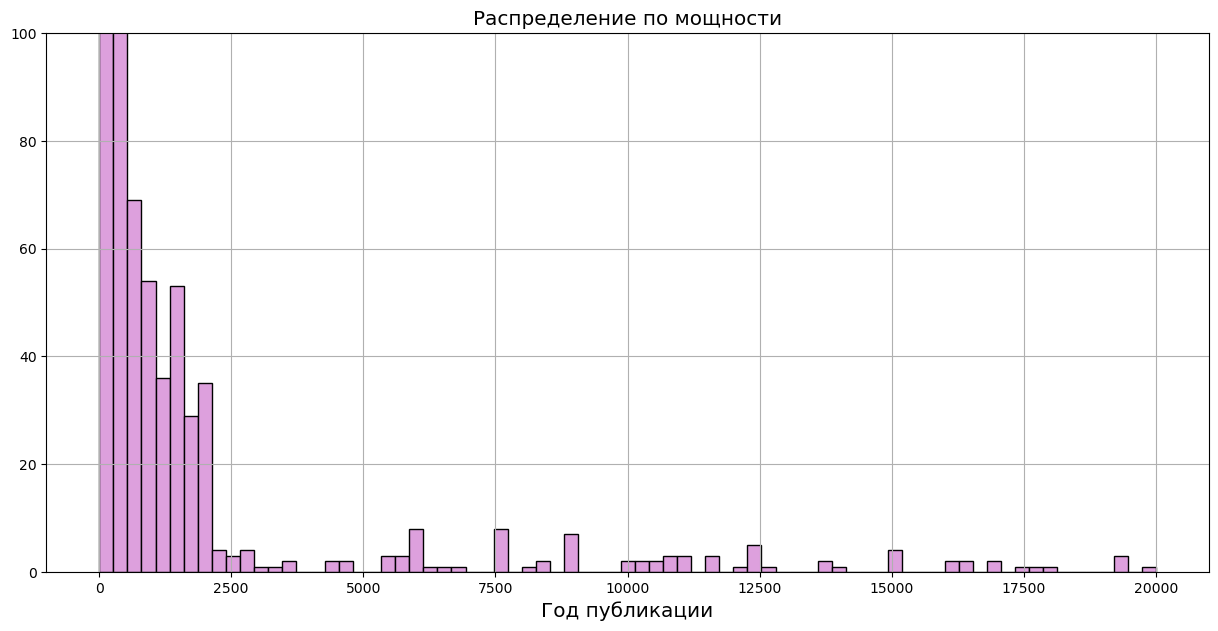

In [27]:
plt.figure(figsize=(15,7))
plt.ylim(0,100)
autos['Power'].hist(bins=75, edgecolor='k', color='plum')
plt.title('Распределение по мощности', fontsize='x-large')
plt.xlabel('Год публикации', fontsize='x-large')
plt.show()

In [28]:
autos.query('Power >= 500')

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat
1815,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no
4054,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no
5316,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown
6282,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes
6487,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...,...
322116,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,unknown
322188,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes
324737,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no
326077,12500,unknown,2017,manual,2000,other,60000,0,gasoline,chrysler,no


In [29]:
autos.query('Power <= 10')

,Price,VehicleType_cat,RegistrationYear,Gearbox_cat,Power,Model_cat,Kilometer,RegistrationMonth,FuelType_cat,Brand_cat,Repaired_cat
431,3950,small,2004,auto,5,unknown,70000,5,gasoline,sonstige_autos,no
3347,1990,small,2004,unknown,7,polo,150000,5,gasoline,volkswagen,no
9524,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,unknown
11796,1999,coupe,1964,manual,10,unknown,150000,6,petrol,sonstige_autos,unknown
12685,2850,small,2005,auto,5,unknown,40000,8,gasoline,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...,...
320174,3700,small,2006,auto,5,unknown,40000,4,gasoline,sonstige_autos,no
322194,1850,small,2003,auto,5,unknown,50000,3,gasoline,sonstige_autos,yes
322783,1500,unknown,2016,unknown,2,unknown,150000,5,gasoline,volkswagen,unknown
325753,8600,convertible,2012,manual,8,unknown,5000,3,gasoline,sonstige_autos,no


Автомобили из таблицы, довольно современные - мощность их двигателей превышает 10 л.с. Кроме одного - Сitroen Convertible C3 1923 года выпуска, который действительно имел мощность 8 л.с. 

Очистим строки с мощностью машин более 500 л.с - 209 строк и меньше 10 л.с.

In [30]:
autos = autos.drop(autos.query('Power >= 500').index).reset_index(drop=True)
autos = autos.drop(autos.query('Power <= 10').index).reset_index(drop=True)
autos = autos.drop(autos.query('RegistrationYear < 1920 or RegistrationYear >= 2020').index).reset_index(drop=True)

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281097 entries, 0 to 281096
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              281097 non-null  int64 
 1   VehicleType_cat    281097 non-null  object
 2   RegistrationYear   281097 non-null  int64 
 3   Gearbox_cat        281097 non-null  object
 4   Power              281097 non-null  int64 
 5   Model_cat          281097 non-null  object
 6   Kilometer          281097 non-null  int64 
 7   RegistrationMonth  281097 non-null  int64 
 8   FuelType_cat       281097 non-null  object
 9   Brand_cat          281097 non-null  object
 10  Repaired_cat       281097 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.6+ MB


Снова проверим дубликаты и удалим их:

In [31]:
print(autos.duplicated().sum())

autos = autos.drop_duplicates().reset_index(drop=True)

0


## Обучение моделей

In [32]:
def time_score(model, features_train, target_train, features_test, target_test):
    
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(features_test)
    predict_time = time.time() - start

    return train_time, predict_time, mean_squared_error(target_test, predict)**0.5

Разделим датасет:

In [33]:
from sklearn.model_selection import train_test_split
features = autos.drop(['Price'], axis = 1)  
target = autos['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=123)

In [34]:
features_train.shape[0], features_valid.shape[0], target_train.shape[0], target_valid.shape[0]

(224877, 56220, 224877, 56220)

In [35]:
features_train[['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat', 'Brand_cat', 'Repaired_cat']] = features_train[['VehicleType_cat', 'Gearbox_cat', 'Model_cat', 'FuelType_cat', 'Brand_cat', 'Repaired_cat']].astype('category')

features_valid[['VehicleType_cat','Gearbox_cat','Model_cat','FuelType_cat','Brand_cat','Repaired_cat']] = features_valid[['VehicleType_cat','Gearbox_cat','Model_cat','FuelType_cat','Brand_cat','Repaired_cat']].astype('category')

In [36]:
category_features = [c for c, col in enumerate(features_train.columns) if '_cat' in col]
category_features

[0, 2, 4, 7, 8, 9]

In [37]:
%%time
import lightgbm as lgb
estim = lgb.LGBMRegressor()
estim.fit(features_train, target_train, eval_metric='rmse', categorical_feature=category_features)
predicted_valid = estim.predict(features_valid)
predicted_train = estim.predict(features_train)
print('The rmse of LGBMRegressor prediction on train:', mean_squared_error(target_train, predicted_train) ** 0.5)
print('The rmse of LGBMRegressor prediction on valid:', mean_squared_error(target_valid, predicted_valid) ** 0.5)

D:\Programs\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


The rmse of LGBMRegressor prediction on train: 1570.577323911215
The rmse of LGBMRegressor prediction on valid: 1605.3174821588534
Wall time: 5.29 s


**Вывод**

Исходя из вычислительного ответа, можно сделать вывод, что модель `LGBMRegressor` достаточно точно предсказывает данные, потому что значение `RMSE` на тренировочной выборке и на валидационной выборке достаточно близко друг к другу.

## Анализ моделей

Разброс значений цены между обучающей и валидационной выборках не сильно большой. Далее надо подобрать параметры для исследования модели с помощью `GridSearchCV`:

In [38]:
%%time
warnings.filterwarnings('ignore')
estim_new = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.01)

param_grid = {
    'n_estimators': [10,50,100,200,250],
    'max_depth': [1,5,10,15,20]
}

cv = KFold(n_splits=3, shuffle=True)
gbm = GridSearchCV(estimator=estim_new, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=1)

gbm.fit(features_train, target_train, categorical_feature=category_features)

print('Best parameters:', gbm.best_params_)
print('Best score:', gbm.best_score_)

Best parameters: {'max_depth': 15, 'n_estimators': 250}
Best score: -3421368.278660521
Wall time: 3min 34s


Полученные параметры:

- Best parameters: {'max_depth': 15, 'n_estimators': 250}
- Best score: -3421368.278660521
- Wall time: 3min 34s

В итоге имеем рекомендованные параметры `max_depth`: 15, `n_estimators`: 250, применим их на модели:

In [44]:
%%time
model = lgb.LGBMRegressor(num_leaves= 31, learning_rate=0.01, max_depth=15, n_estimators=250)
model.fit(features_train, target_train, categorical_feature=category_features)
predicted_valid1 = model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid1))**0.5

rmse

Wall time: 8.3 s


1829.2606971412679

In [45]:
import time
result = []
result.append(time_score(model, features_train, target_train, features_valid, target_valid))

Обучим `CatBoost`:

In [46]:
%%time
model_cat = CatBoostRegressor(n_estimators = 200, loss_function = 'MAE', eval_metric = 'RMSE', cat_features = category_features)
model_cat.fit(features_train, target_train, cat_features=category_features, verbose=10)
predicted_valid2 = model_cat.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid2))**0.5
rmse

0:	learn: 4807.2981201	total: 600ms	remaining: 1m 59s
10:	learn: 4041.3561709	total: 4.62s	remaining: 1m 19s
20:	learn: 3496.7209358	total: 8.58s	remaining: 1m 13s
30:	learn: 3112.9573294	total: 12.7s	remaining: 1m 9s
40:	learn: 2820.8363022	total: 16.8s	remaining: 1m 5s
50:	learn: 2601.8348449	total: 20.8s	remaining: 1m
60:	learn: 2442.1490425	total: 25s	remaining: 56.9s
70:	learn: 2315.4224692	total: 29.1s	remaining: 52.8s
80:	learn: 2224.4508935	total: 32.8s	remaining: 48.1s
90:	learn: 2154.6406419	total: 36.3s	remaining: 43.5s
100:	learn: 2100.4679440	total: 40.3s	remaining: 39.5s
110:	learn: 2057.0032657	total: 44s	remaining: 35.3s
120:	learn: 2019.8313145	total: 48s	remaining: 31.4s
130:	learn: 1987.7283423	total: 52.3s	remaining: 27.6s
140:	learn: 1963.1315739	total: 56.3s	remaining: 23.6s
150:	learn: 1944.4525740	total: 1m	remaining: 19.6s
160:	learn: 1928.2675269	total: 1m 4s	remaining: 15.6s
170:	learn: 1913.8590433	total: 1m 8s	remaining: 11.6s
180:	learn: 1900.1962442	total

1863.6531256863307

In [47]:
result.append(time_score(model_cat, features_train, target_train, features_valid, target_valid))

0:	learn: 4807.2981201	total: 634ms	remaining: 2m 6s
1:	learn: 4722.4526862	total: 1.17s	remaining: 1m 55s
2:	learn: 4633.8664223	total: 1.65s	remaining: 1m 48s
3:	learn: 4550.3373059	total: 2.14s	remaining: 1m 44s
4:	learn: 4470.8174473	total: 2.6s	remaining: 1m 41s
5:	learn: 4387.2622069	total: 3s	remaining: 1m 37s
6:	learn: 4313.7216638	total: 3.35s	remaining: 1m 32s
7:	learn: 4244.0001672	total: 3.73s	remaining: 1m 29s
8:	learn: 4178.8520342	total: 4.08s	remaining: 1m 26s
9:	learn: 4111.5213886	total: 4.49s	remaining: 1m 25s
10:	learn: 4041.3561709	total: 4.89s	remaining: 1m 24s
11:	learn: 3976.1141016	total: 5.29s	remaining: 1m 22s
12:	learn: 3922.4650803	total: 5.71s	remaining: 1m 22s
13:	learn: 3864.7744655	total: 6.09s	remaining: 1m 20s
14:	learn: 3811.6138856	total: 6.43s	remaining: 1m 19s
15:	learn: 3755.2212823	total: 6.82s	remaining: 1m 18s
16:	learn: 3697.5395287	total: 7.19s	remaining: 1m 17s
17:	learn: 3643.7692871	total: 7.63s	remaining: 1m 17s
18:	learn: 3591.3697476	t

In [48]:
pd.DataFrame(data=result,
index=['LightGBM', 'CatBoost'],
columns=['Время_обучения', 'Время_Предсказания', 'RMSE'])

,Время_обучения,Время_Предсказания,RMSE
LightGBM,6.878146,0.770526,1829.260697
CatBoost,87.589934,0.157204,1863.653126


**Вывод**

На основании представленных показателей можно сделать вывод, что `LightGBM` обучается быстрее и дает более точные прогнозы (меньший `RMSE`), но в то же время требует больше времени на предсказание. `CatBoost` же обладает более быстрым временем предсказания, но обучается значительно медленнее и дает менее точные результаты. Так как для заказчика наиболее важными является скорость обучения и высокая точность прогнозов, то выбираем модель `LightGBM`.